In [1]:
import math

In [136]:
class Value:
    def __init__(self, data:float, _op:str = '', _prev:tuple=(), label=''):
        self.data = data
        self._op = _op
        self._prev = _prev #making this a set changes the topological sort for some reason (bias becomes first added, in the example)
        self.grad = 0.0 #initially has no effect on the function
        self._backward = lambda: None
        self.label = label
    def __repr__(self):
        return f'Value({self.data})'
    def __add__(self, b):
        val = Value(self.data + b.data, _op= '+', _prev=(self, b))
        def _backward():
            self.grad += 1.0*val.grad ## NOTE: We require += because of gradient accumlation within a pass. e.g. b = a+a. The gradient of a here is 2, rather than 1. += takes care of that.
            b.grad += 1.0*val.grad
        val._backward = _backward
        return val

    def __mul__(self, b):
        val= Value(self.data* b.data, _op= '*', _prev=(self, b))
        def _backward():
            self.grad += b.data*val.grad
            b.grad += self.data*val.grad
        val._backward = _backward
        return val
    
    def relu(self):
        if self.data >= 0:
            value = self.data
        else:
            value = 0
        val= Value(value, _op='relu', _prev=(self,))
        def _backward():
            if val.data >0:
                self.grad+= 1.0*val.grad
            else:
                self.grad = 0
        val._backward= _backward
        return val
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        val = Value(t, _prev=(self, ), _op='tanh')
        def _backward():
            self.grad = (1-t**2)*val.grad #derivative of tanh = 1-tanh**2
        val._backward = _backward
        return val
    
    def backward(self):
        order = []
        visited = set()
        def topological_sort(node):
            if node not in visited:
                print(node) #if node hasn't been visited
                visited.add(node)   # add it to the visited set
                for prev in node._prev: # Keep iterating through to the children nodes
                    topological_sort(prev) # run again
                order.append(node)        # Only once children nodes are done, add the parent
        topological_sort(self)

        self.grad = 1.0
        for node in reversed(order):
            node._backward() 

In [54]:
a = Value(3, label='a')
b = Value(-4, label='b')
c = a * b
c.label='c'

In [55]:
c.data

-12

In [56]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

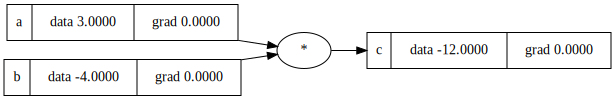

In [57]:
draw_dot(c)

In [58]:
a = Value(3.0)
h = 0.0001
b = Value(4+h)
c1 = a + b

a = Value(3)
b = Value(4)
c2 = a+b

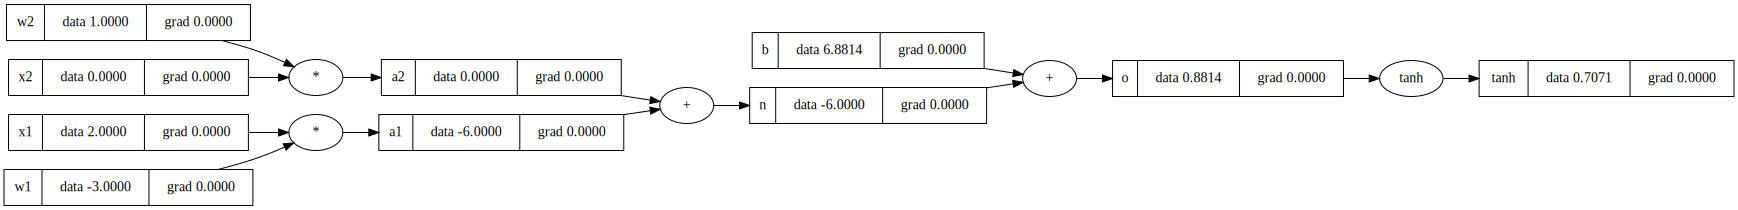

In [59]:
b = Value(6.8814, label='b')
w1 = Value(-3, label = 'w1')
x1 = Value(2, label = 'x1')
a1 = (w1*x1)
a1.label = 'a1'
w2 = Value(1, label = 'w2')
x2 = Value(0, label = 'x2')
a2 =  (w2*x2)
a2.label='a2'
n = a1 + a2
n.label='n'
o = n + b
o.label='o'
r = o.tanh()
r.label='tanh'
# c.grad = 1.0
draw_dot(r)

Manual Backpropagation

In [28]:
r.grad = 1.0
r._backward()

In [29]:
o._backward()
b._backward()
n._backward()
a2._backward()
x2._backward()
w2._backward()
a1._backward()
x1._backward()
w1._backward()

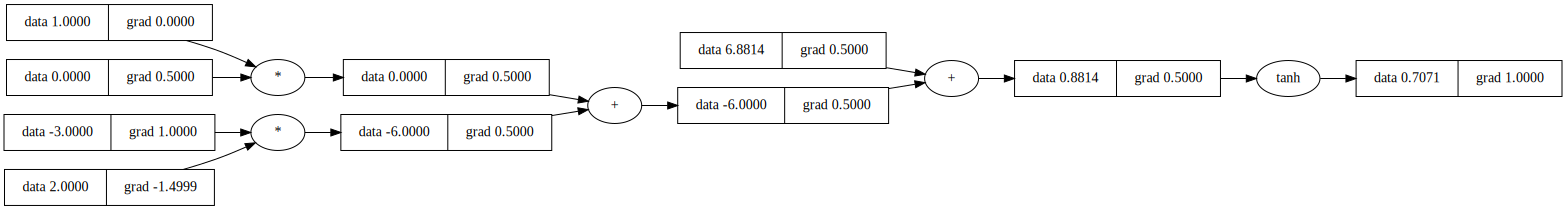

In [30]:
draw_dot(r)

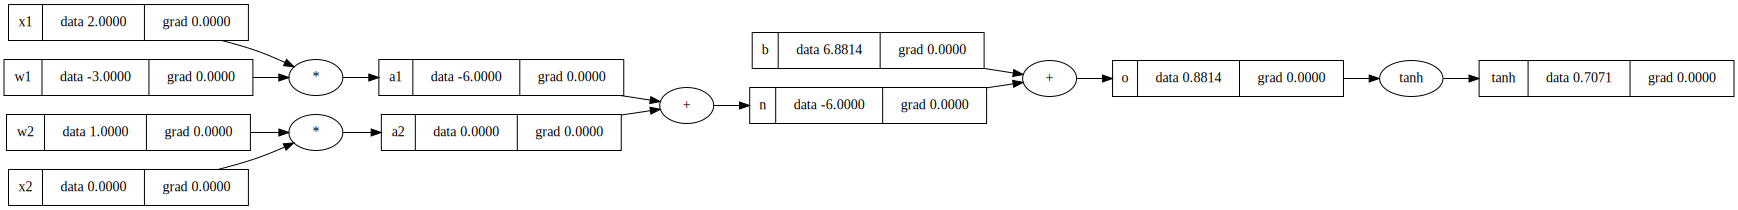

In [137]:
b = Value(6.8814, label='b')
w1 = Value(-3, label = 'w1')
x1 = Value(2, label = 'x1')
a1 = (w1*x1)
a1.label = 'a1'
w2 = Value(1, label = 'w2')
x2 = Value(0, label = 'x2')
a2 =  (w2*x2)
a2.label='a2'
n = a1 + a2
n.label='n'
o = n + b
o.label='o'
r = o.tanh()
r.label='tanh'
# c.grad = 1.0
draw_dot(r)

In [144]:
#We need to create a function which will iterate through each node, in a "flattened" way: topological sort
order = []
visited = set()
def return_children(node):
    if node not in visited:
        visited.add(node)   # add it to the visited set
        for prev in node._prev: # Keep iterating through to the children nodes
            return_children(prev) # run again
        order.append(node)        # Only once children nodes are done, add the parent
return_children(r)
for node in order:
    print(node.label)

w1
x1
a1
w2
x2
a2
n
b
o
tanh


In [142]:
order.reverse()

In [143]:
order

[Value(0.7071199874301227),
 Value(0.8814000000000002),
 Value(6.8814),
 Value(-6),
 Value(0),
 Value(0),
 Value(1),
 Value(-6),
 Value(2),
 Value(-3)]

Value(0.7071199874301227)
Value(0.8814000000000002)
Value(-6)
Value(-6)
Value(-3)
Value(2)
Value(0)
Value(1)
Value(0)
Value(6.8814)


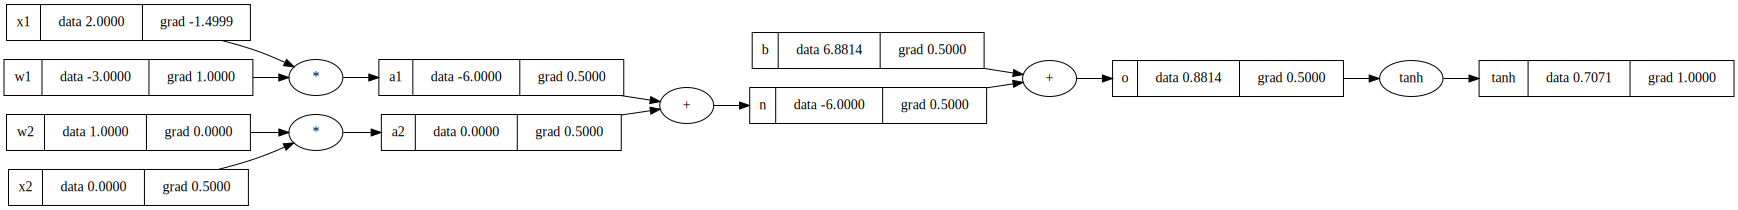

In [139]:
r.backward()
draw_dot(r)

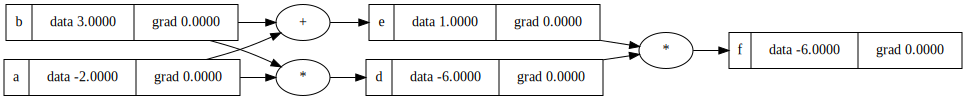

In [64]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label='b')
d = a*b ; d.label='d'
e = a+b ; e.label = 'e'
f = d*e ; f.label= 'f'
draw_dot(f)

In [ ]:
set()